In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import xgboost as xgb
from sklearn.svm import SVC

In [ ]:
reddit_data= pd.read_csv("reddit_all_scraped_dataset_new.csv")

In [ ]:
reddit_data["created"] = pd.to_datetime(reddit_data["created"])

reddit_data["hour"] = reddit_data["created"].dt.hour


In [ ]:
# Map the hour component to time categories
reddit_data["time_category"] = reddit_data["hour"].apply(lambda hour:
    "Morning" if 6 <= hour < 12
    else "Noon" if 12 <= hour < 16
    else "Afternoon" if 16 <= hour < 20
    else "Night" if 20 <= hour < 23.59
    else "Late Night"

)


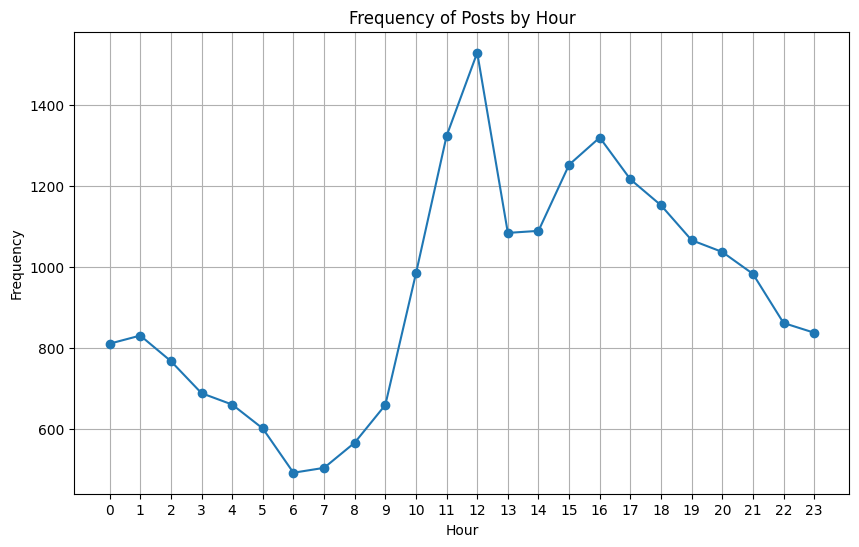

In [ ]:
# Count the frequency of each hour
hour_counts = reddit_data["hour"].value_counts().sort_index()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(hour_counts.index, hour_counts.values, marker='o', linestyle='-')
plt.title('Frequency of Posts by Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(24))  # Ensure ticks for all 24 hours
plt.show()

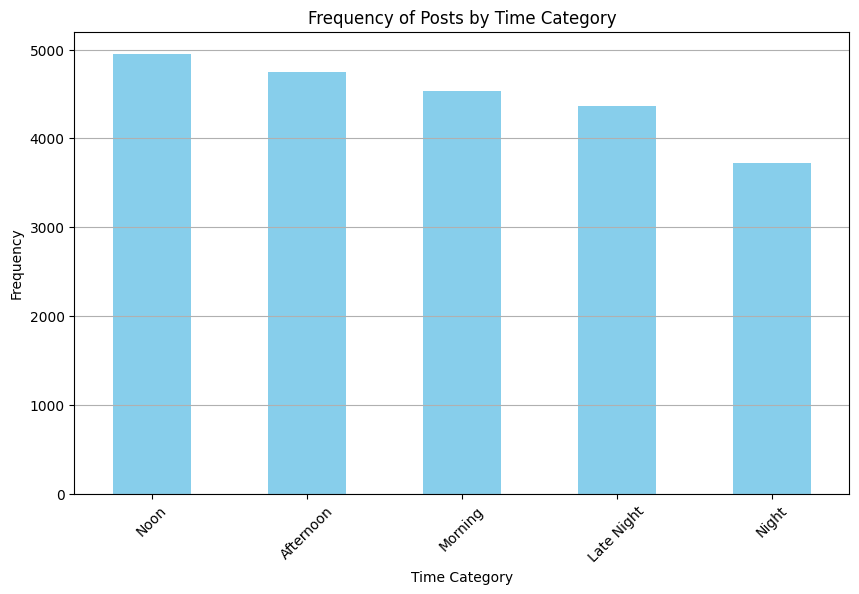

In [ ]:
# Count the frequency of each time category
category_counts = reddit_data["time_category"].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Posts by Time Category')
plt.xlabel('Time Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines along the y-axis
plt.show()

In [ ]:
df_categories= reddit_data.copy()

In [ ]:
# Drop rows with missing values in necessary columns
reddit_data_for_reg = df_categories.dropna(subset=["title", "score", "time_category", "category"])

# Convert score column to float
reddit_data_for_reg["score"] = reddit_data_for_reg["score"].astype(float)

# Split data into features and target variable
X = reddit_data_for_reg[["title", "score", "category"]]
y = reddit_data_for_reg["time_category"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Train Word2Vec model on the training data
word2vec_model = Word2Vec(sentences=X_train["title"], vector_size=100, window=5, min_count=1, workers=4)

# Function to convert title to Word2Vec vectors
def word2vec_transform(titles):
    return np.array([np.mean([word2vec_model.wv[word] for word in title.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for title in titles])

# Define the preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ("word2vec", FunctionTransformer(word2vec_transform), "title"),
    ("count_vectorizer", CountVectorizer(), "title"),
])

# Encode the category separately
category_encoder = LabelEncoder()
X_train["category"] = category_encoder.fit_transform(X_train["category"])
X_test["category"] = category_encoder.transform(X_test["category"])

# Combine preprocessing with classifier
pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("classifier", RandomForestClassifier())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


<ipython-input-28-c624183bb098>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data_for_reg["score"] = reddit_data_for_reg["score"].astype(float)


Accuracy: 0.5826612903225806


In [ ]:
print("Accuracy:", accuracy)

Accuracy: 0.5770609318996416


In [ ]:
X_test

,title,score,category
16175,Wife has gently suggested she prefers short hair,2272.0,1
9215,What are your Outlook productivity tips?,4.0,0
15848,Amazing,2988.0,1
5927,My little bean,10.0,2
13391,Water companies in England face outrage over r...,330.0,1
...,...,...,...
9785,Quick productivity tip! Set an alarm for 15 mi...,903.0,0
18450,If by “old school” you mean a “corporate bootl...,2748.0,4
20044,Social service job available,2.0,4
21036,how to change careers from GP to anos?,1.0,4


In [ ]:
X_test.reset_index(drop=True, inplace=True)

In [ ]:
from collections import defaultdict, Counter
from tabulate import tabulate

# Create a dictionary to store predictions for each category
category_predictions = defaultdict(list)

# Iterate over the indices of the test dataset
for idx in X_test.index:
    category = X_test.loc[idx, "category"]
    # Ensure the index exists in the predictions array
    if idx < len(predictions):
        prediction = predictions[idx]
        category_predictions[category].append(prediction)
    else:
        print(f"No prediction for index {idx}")

time_categories = ['Morning', 'Noon', 'Afternoon', 'Night', 'Late Night']

# Define a dictionary to map category indices to category names
category_names = {
    0: "Science & Tech",
    1: "Work",
    2: "Inspiration",
    3: "Education & Self-Improvement",
    4: "Events"
}

# Prepare data for tabulate
table_data = []

# Find the most common 'time category' for each category
for category, predictions_list in category_predictions.items():
    if predictions_list:  # Check if there are predictions for the category
        # Count the occurrences of each 'time category' prediction
        time_category_counts = Counter(predictions_list)

        # Find the most common 'time category'
        most_common_time_category = max(time_category_counts, key=time_category_counts.get)

        # Find the index of the most common time category within the time_categories list
        most_common_time_category_index = time_categories.index(most_common_time_category)

        # Use the index to get the corresponding label
        most_common_time_category_label = time_categories[most_common_time_category_index]

        # Map the numerical category index to its name
        category_name = category_names[category]

        table_data.append([category_name, most_common_time_category_label])
    else:
        table_data.append([category_name, "No predictions"])

# Print the results in a table
print(tabulate(table_data, headers=["Category", "Best Time Category"], tablefmt="grid"))


+------------------------------+----------------------+
| Category                     | Best Time Category   |
+==============================+======================+
| Work                         | Noon                 |
+------------------------------+----------------------+
| Science & Tech               | Afternoon            |
+------------------------------+----------------------+
| Inspiration                  | Late Night           |
+------------------------------+----------------------+
| Education & Self-Improvement | Morning              |
+------------------------------+----------------------+
| Events                       | Afternoon            |
+------------------------------+----------------------+


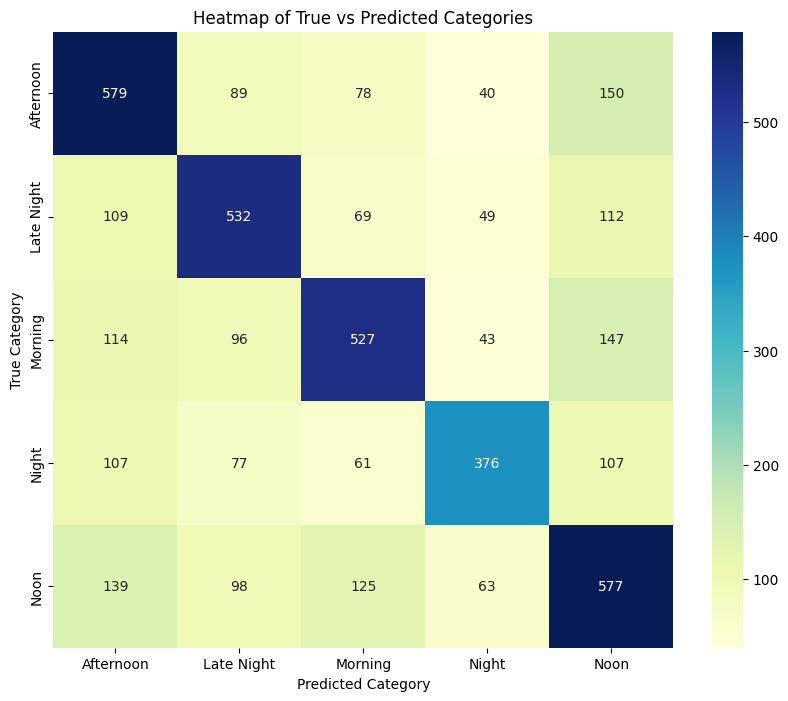

In [ ]:
predictions_df = pd.DataFrame({'True Category': y_test, 'Predicted Category': predictions})

heatmap_data = predictions_df.groupby(['True Category', 'Predicted Category']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d", cbar=True)
plt.title('Heatmap of True vs Predicted Categories')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()